# Partial least squares correlation (PLSC) analysis

In [1]:
import sys
import numpy as np
sys.path.append("../code/")
subj_list = list(np.loadtxt('../code/subject_list_exclusions.txt', dtype='str'))

Some parameters to consider:
- whether the ROIs are eroded
- the number of PCA inputs (explored more later)

In [2]:
import pickle
from functions.data_helpers import get_phenotype

# parameters to consider:
eroded = False
n_X = 5
n_y = 5
n_comps = 2  # number of PLS components to investigate

# load the data
in_file = ('../results/PLSC/'
            + 'eroded-'+str(eroded)
            + '_Xnum-'+str(n_X)
            + '_ynum-'+str(n_y)
            + '.pkl')
with open(in_file, 'rb') as f:
    bpls = pickle.load(f)
    bpls_rev = pickle.load(f)
print('Results loaded')

# organise the results into dfs
pls_df = get_phenotype(subj_list, ['participants'])

# report the correlation and pval
for i in range(n_comps):
    print('Component',i)
    print('\tr=', np.corrcoef(bpls.x_scores[:,i], bpls.y_scores[:,i])[0,1])
    print('\tpFWE=',np.real(bpls.permres.pvals[i]))

    #save x/y_scores
    pls_df['X_scores_'+str(i)] = bpls.x_scores[:,i].copy()
    pls_df['y_scores_'+str(i)] = bpls.y_scores[:,i].copy()

Results loaded
Component 0
	r= 0.3934600917416647
	pFWE= 0.0027498625068746564
Component 1
	r= 0.1878181700034734
	pFWE= 0.16334183290835458


## Plot the significant PLS relationship

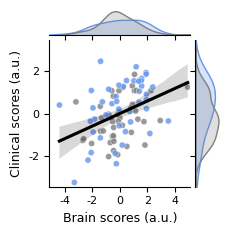

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

palette = ['gray', 'cornflowerblue']
fig_dir = '../figures/'

# only the first component is significant
component = 0

# create scatter figure
xmax = max(abs(pls_df['X_scores_'+str(component)].values))+0.2
xmin = xmax*-1
ymax = max(abs(pls_df['y_scores_'+str(component)].values))+0.2
ymin = ymax*-1
plt.rcParams['svg.fonttype'] = 'none'

g = sns.jointplot(data=pls_df,
              x='X_scores_'+str(component),
              y='y_scores_'+str(component),
              hue='group',
              height=2.5,
              s=20,
              alpha=0.8,
              xlim=[xmin, xmax],
              ylim=[ymin, ymax],
              legend=False,
              palette=palette)

sns.regplot(data=pls_df,
            x='X_scores_'+str(component),
            y='y_scores_'+str(component),
            color='k', ax=g.ax_joint,
            scatter=False)

# change ticks and sizes
g.set_axis_labels(xlabel='Brain scores (a.u.)',
                  ylabel='Clinical scores (a.u.)', size=9)
ticks = np.arange(int(np.ceil(xmin)), int(np.ceil(xmax)))
if len(ticks) > 5:
    ticks = ticks[ticks % 2 == 0]
g.ax_joint.set_xticks(ticks)
g.ax_joint.set_xticklabels(ticks, fontsize=8)

ticks = np.arange(int(np.ceil(ymin)), int(np.ceil(ymax)))
if len(ticks) > 5:
    ticks = ticks[ticks % 2 == 0]
g.ax_joint.set_yticks(ticks)               
g.ax_joint.set_yticklabels(ticks, fontsize=8)

plt.savefig(fig_dir+'PLSC_correlation.svg', dpi=300, pad_inches=0.2)
plt.show()

## Examine the raw PCA weights, bootstraps and whether PCA numbers influence the results
These are not easily interpretable because there is no obvious correspondance to the input variables. You would have to go ahead and plot the weights of each PCA component (perhaps in supplementary)

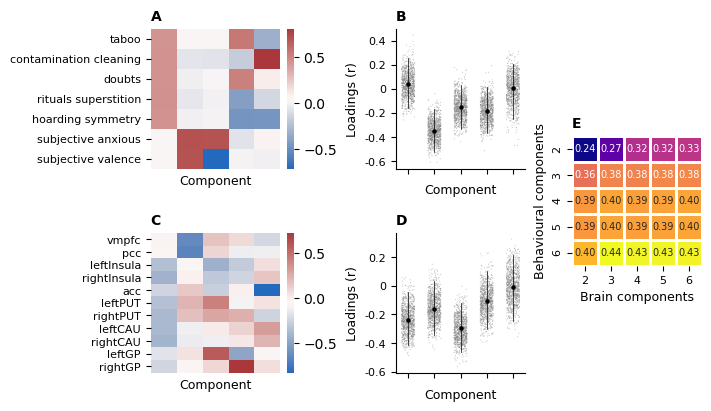

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# weight plots
fig, axs = plt.subplot_mosaic("""
                              CAE
                              DBE
                              """, figsize=(7, 4), constrained_layout=True)
plt.rcParams['svg.fonttype'] = 'none'


## Top plot: pca weights
df = pd.read_csv('../results/PLSC/y_raw.csv')
y_labels = df.columns.copy()[0:-1]

converter = lambda x: x.replace('_', ' ') # replace the underscores...
y_labels = list(map(converter, y_labels))
converter = lambda x: x.replace('factor ', '')
y_labels = list(map(converter, y_labels))

df.drop(labels='subj',axis='columns', inplace=True)
y_scaled = StandardScaler().fit_transform(df.values)

# perform PCA on y
pca = PCA(n_components=n_y).fit(y_scaled)
components = pca.components_.copy().T


sns.heatmap(data=components, linewidths=0, cbar=True, cmap='vlag', ax=axs['C'],
            yticklabels=y_labels, xticklabels=[])

axs['C'].set_xlabel('Component', fontsize=9)
axs['C'].tick_params(labelsize=8)
axs['C'].set_title('A', fontsize=10, weight='bold', loc='left')

# brain stuff (X)
df = pd.read_csv('../results/PLSC/X_raw.csv')
y_labels = df.columns.copy()[0:-1]
df.drop(labels='subj',axis='columns', inplace=True)
y_scaled = StandardScaler().fit_transform(df.values)

# perform PCA on y
pca = PCA(n_components=n_y).fit(y_scaled)
components = pca.components_.copy().T
sns.heatmap(data=components, linewidths=0, cbar=True, cmap='vlag', ax=axs['D'],
            yticklabels=y_labels, xticklabels=[])

axs['D'].set_xlabel('Component', fontsize=9)
axs['D'].tick_params(labelsize=8)
axs['D'].set_title('C', fontsize=10, weight='bold', loc='left')

## Bottom Plot: bootstraps
# we only want to keep a small number of bootstraps
# for visualisation otherwise the figure size
# gets out of hand
n_boots = 1000
y_labels = np.arange(1, n_y+1)
data = bpls.bootres.y_loadings_boot[:, component, :].T
ind = np.random.randint(0, data.shape[0], n_boots)
data = data[ind, :]
loadings = pd.DataFrame(data=data, columns=y_labels)
loadings = loadings.melt(value_vars=y_labels)

# plot y loadings
g = sns.stripplot(data=loadings,
              x='variable',
              y='value',
              color='grey',
              order = y_labels,
              alpha=0.50,
              size=0.75,
              jitter=0.25,
              ax=axs['A'],
              zorder=0)

# change the fontsize / labels
axs['A'].set_xlabel('Component', size=9)
axs['A'].set_ylabel('Loadings (r)', size=9)

axs['A'].set_xticks(range(n_y+1))
axs['A'].set_xticklabels('', fontsize=8)
yticks = [-0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6]
axs['A'].set_yticks(yticks)
axs['A'].set_yticklabels(yticks, fontsize=8)

# plot CIs (these are calculated from ALL bootstraps)
for i in range(bpls.bootres.y_loadings_ci.shape[0]):
    ci = bpls.bootres.y_loadings_ci[i, component]
    axs['A'].plot( [i, i], [ci[0], ci[1]], 'k', linewidth=0.5, zorder=1)

# plot means
x = range(len(bpls.bootres.y_loadings[:,component]))
axs['A'].scatter(x, bpls.bootres.y_loadings[:, component], color='k', s=5, zorder=1)
sns.despine(ax=axs['A'])
axs['A'].set_title('B', fontsize=10, weight='bold', loc='left')

# plot the X loadings!
data = bpls_rev.bootres.y_loadings_boot[:, component, :].T
ind = np.random.randint(0, data.shape[0], n_boots)
data = data[ind, :]
loadings = pd.DataFrame(data=data, columns=y_labels)
loadings = loadings.melt(value_vars=y_labels)

# plot X loadings
g = sns.stripplot(data=loadings,
              x='variable',
              y='value',
              color='grey',
              order = y_labels,
              alpha=0.50,
              size=0.75,
              jitter=0.25,
              ax=axs['B'],
              zorder=0)

# change the fontsize / labels
axs['B'].set_xlabel('Component', size=9)
axs['B'].set_ylabel('Loadings (r)', size=9)

axs['B'].set_xticks(range(n_y+1))
axs['B'].set_xticklabels('', fontsize=8)
yticks = [-0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6]
axs['B'].set_yticks(yticks)
axs['B'].set_yticklabels(yticks, fontsize=8)

# plot CIs (these are calculated from ALL bootstraps)
for i in range(bpls_rev.bootres.y_loadings_ci.shape[0]):
    ci = bpls_rev.bootres.y_loadings_ci[i, component]
    axs['B'].plot( [i, i], [ci[0], ci[1]], 'k', linewidth=0.5, zorder=1)

# plot means
x = range(len(bpls_rev.bootres.y_loadings[:,component]))
axs['B'].scatter(x, bpls_rev.bootres.y_loadings[:, component], color='k', s=5, zorder=1)
sns.despine(ax=axs['B'])
axs['B'].set_title('D', fontsize=10, weight='bold', loc='left')

r_mat = np.zeros((5,5))

for n_X in range(2,7):
    for n_y in range(2,7):

        # load the data
        in_file = ('../results/PLSC/'
                    + 'eroded-'+str(eroded)
                    + '_Xnum-'+str(n_X)
                    + '_ynum-'+str(n_y)
                    + '.pkl')
        with open(in_file, 'rb') as f:
            bpls = pickle.load(f)
            bpls_rev = pickle.load(f)

        # we just want to collect the first (sig) components r value
        r = np.corrcoef(bpls.x_scores[:,0], bpls.y_scores[:,0])[0,1]
        r_mat[n_X-2,n_y-2] = r.copy()


sns.heatmap(data=r_mat, linewidths=1, cbar=False, cmap='plasma', square=True,
            annot=True, fmt='.2f', annot_kws={"size": 7},
            xticklabels=['2', '3', '4', '5', '6'],
            yticklabels=['2', '3', '4', '5', '6'], ax=axs['E'])
axs['E'].set_xlabel('Brain components', fontsize=9)
axs['E'].set_ylabel('Behavioural components', fontsize=9)

axs['E'].tick_params(labelsize=8)
axs['E'].set_title('E', fontsize=10, weight='bold', loc='left')
plt.savefig('../figures/PLSC_PCA_reliability.png')
plt.show()

## Plot the correlation between the PLS and the raw data
Technically, the statistic is not performed on these, so no CIs, but these are more interpretable than the above PCA components.

Dear future Luke. You changed all these colors to help with interpretation before realising this colormap actually HINDERS the CORRECT interpretation

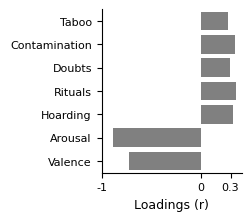

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import spearmanr


fig, axs = plt.subplot_mosaic("""
                              A
                              """, figsize=(2.4, 2.1), constrained_layout=True)
plt.rcParams['svg.fonttype'] = 'none'

# plot y (behav) loadings
y_labels_neat = ['Taboo', 'Contamination', 'Doubts',
                 'Rituals', 'Hoarding',
                 'Arousal',
                 'Valence']

# get the raw data
y_raw = pd.read_csv('../results/PLSC/y_raw.csv')
y_raw = y_raw.drop(columns=['subj'])
y_raw_data = y_raw.values

# correlate with individual PLSC weights
a = bpls.y_scores[:,0]
r_y = []
for b_index in range(y_raw_data.shape[1]):
    b = y_raw_data[:, b_index]
    r, p = spearmanr(a, b)
    r_y.append(r)

plot_df = pd.DataFrame()
plot_df['variable'] = y_labels_neat
plot_df['correlation'] = r_y.copy()
sns.barplot(data=plot_df, y='variable', x='correlation', color='grey')

# change the fontsize / labels
axs['A'].set_yticklabels(y_labels_neat, fontsize=8)
axs['A'].set_xlabel('Loadings (r)', size=9)
axs['A'].set_ylabel('')
xticks = [-1, 0, 0.3]
axs['A'].set_xticks(xticks)
axs['A'].set_xticklabels(xticks, fontsize=8)
sns.despine(ax=axs['A'])
plt.savefig('../figures/PLSC_Behav_correlations.svg', dpi=300, pad_inches=0.2)
plt.show()

In [6]:
#  brain plots
import nibabel as nib
from nilearn import plotting
from nilearn.image import new_img_like
from functions.data_helpers import get_computer

_, proj_dir = get_computer()

# roi information for plotting and statistics
bg_img = (proj_dir + 'data/derivatives/masks/'
          + 'tpl-MNI152NLin2009cAsym_res-01_desc-brain_T1w.nii.gz')
roi_dir = proj_dir+'data/derivatives/masks/'

# this order can be found in the PLSC_analysis script.
roi_dict = {'vmPFC': {'contrast': 'Safety',
                                  'label': ['vmpfc'],
                      'files': [roi_dir+'Savage_safety_vmpfc.nii.gz']
                      },
            'PCC': {'contrast': 'Safety',
                    'label': ['pcc'],
                    'files': [roi_dir+'Savage_safety_pcc.nii.gz']
                    },
            'Insula (left)': {'contrast': 'Threat',
                              'label': ['leftInsula'],
                              'files': [roi_dir+'Savage_threat_leftInsula.nii.gz']
                              },
            'Insula (right)': {'contrast': 'Threat',
                               'label': ['rightInsula'],
                               'files': [roi_dir+'Savage_threat_rightInsula.nii.gz']
                               },
            'dACC': {'contrast': 'Threat',
                     'label': ['acc'],
                     'files': [roi_dir+'Savage_threat_acc.nii.gz']
                     },

            'Putamen (left)': {'contrast': 'Threat',
                               'label': ['leftPUT'],
                               'files': [roi_dir+'tian_threat_leftPUT.nii.gz']
                               },
            'Putamen (right)': {'contrast': 'Threat',
                                'label': ['rightPUT'],
                                'files': [roi_dir+'tian_threat_rightPUT.nii.gz']
                                },
            'Caudate (left)': {'contrast': 'Threat',
                               'label': ['leftCAU'],
                               'files': [roi_dir+'tian_threat_leftCAU.nii.gz']
                               },
            'Caudate (right)': {'contrast': 'Threat',
                                'label': ['rightCAU'],
                                'files': [roi_dir+'tian_threat_rightCAU.nii.gz']
                                },
            'Globus pallidus (left)': {'contrast': 'Threat',
                                       'label': ['leftGP'],
                                       'files': [roi_dir+'tian_threat_leftGP.nii.gz']
                                       },
            'Globus pallidus (right)': {'contrast': 'Threat',
                                        'label': ['rightGP'],
                                        'files': [roi_dir+'tian_threat_rightGP.nii.gz']
                                        }
            }
# start figure
# get correlation values
X_raw = pd.read_csv('../results/PLSC/X_raw.csv')
X_raw = X_raw.drop(columns=['subj'])
X_raw_data = X_raw.values

a = bpls.x_scores[:, 0]
r_X = []
for b_index in range(X_raw_data.shape[1]):
    b = X_raw_data[:, b_index]
    r, p = spearmanr(a, b)
    r_X.append(r)
data = r_X.copy()

# create a brain image that has the values of the results
# in the space of the regions of interest
template = nib.load(roi_dict['PCC']['files'][0])
mask = np.zeros((template.shape))
for i, roi in enumerate(roi_dict):
    # load the roi
    roi_nii = nib.load(roi_dict[roi]['files'][0])

    # index and use value
    mask[roi_nii.get_fdata() == 1] = data[i] *-1  # to fit colormap

mask_nii = new_img_like(template, mask)

cut_coords = [2, 1]
plotting.plot_stat_map(mask_nii,
                       bg_img=bg_img,
                       cut_coords=cut_coords,
                       cmap='RdYlBu',
                       annotate=False,
                       draw_cross=False,
                       black_bg=False,
                       symmetric_cbar=True,
                       resampling_interpolation='continuous',
                       vmax=1,
                       output_file='../figures/PLSC_Brain_correlations.svg',
                       display_mode='xz')
plt.show()


/home/lukeh/miniconda3/envs/py39/lib/python3.9/site-packages/nilearn/datasets/__init__.py:93: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


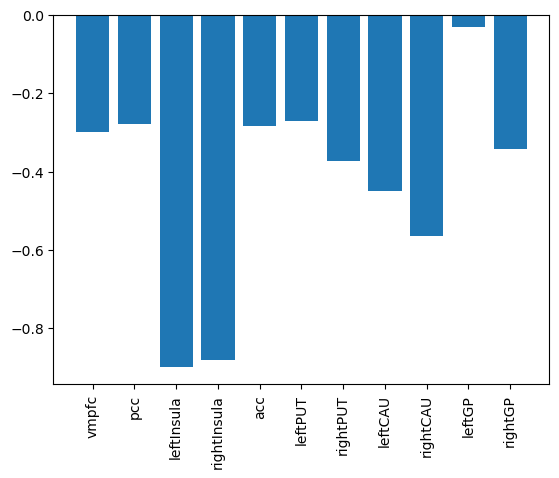

In [7]:
X_raw = pd.read_csv('../results/PLSC/X_raw.csv')
X_raw = X_raw.drop(columns=['subj'])
X_raw_data = X_raw.values

a = bpls.x_scores[:,0]
r_X = []
for b_index in range(X_raw_data.shape[1]):
    b = X_raw_data[:, b_index]
    r, p = spearmanr(a, b)
    r_X.append(r)

plt.bar(range(len(r_X)), r_X)
plt.xticks(range(len(r_X)), labels=X_raw.columns, rotation=90)
plt.show()

## Unpacking the PLS
Just confirming the interpretation...

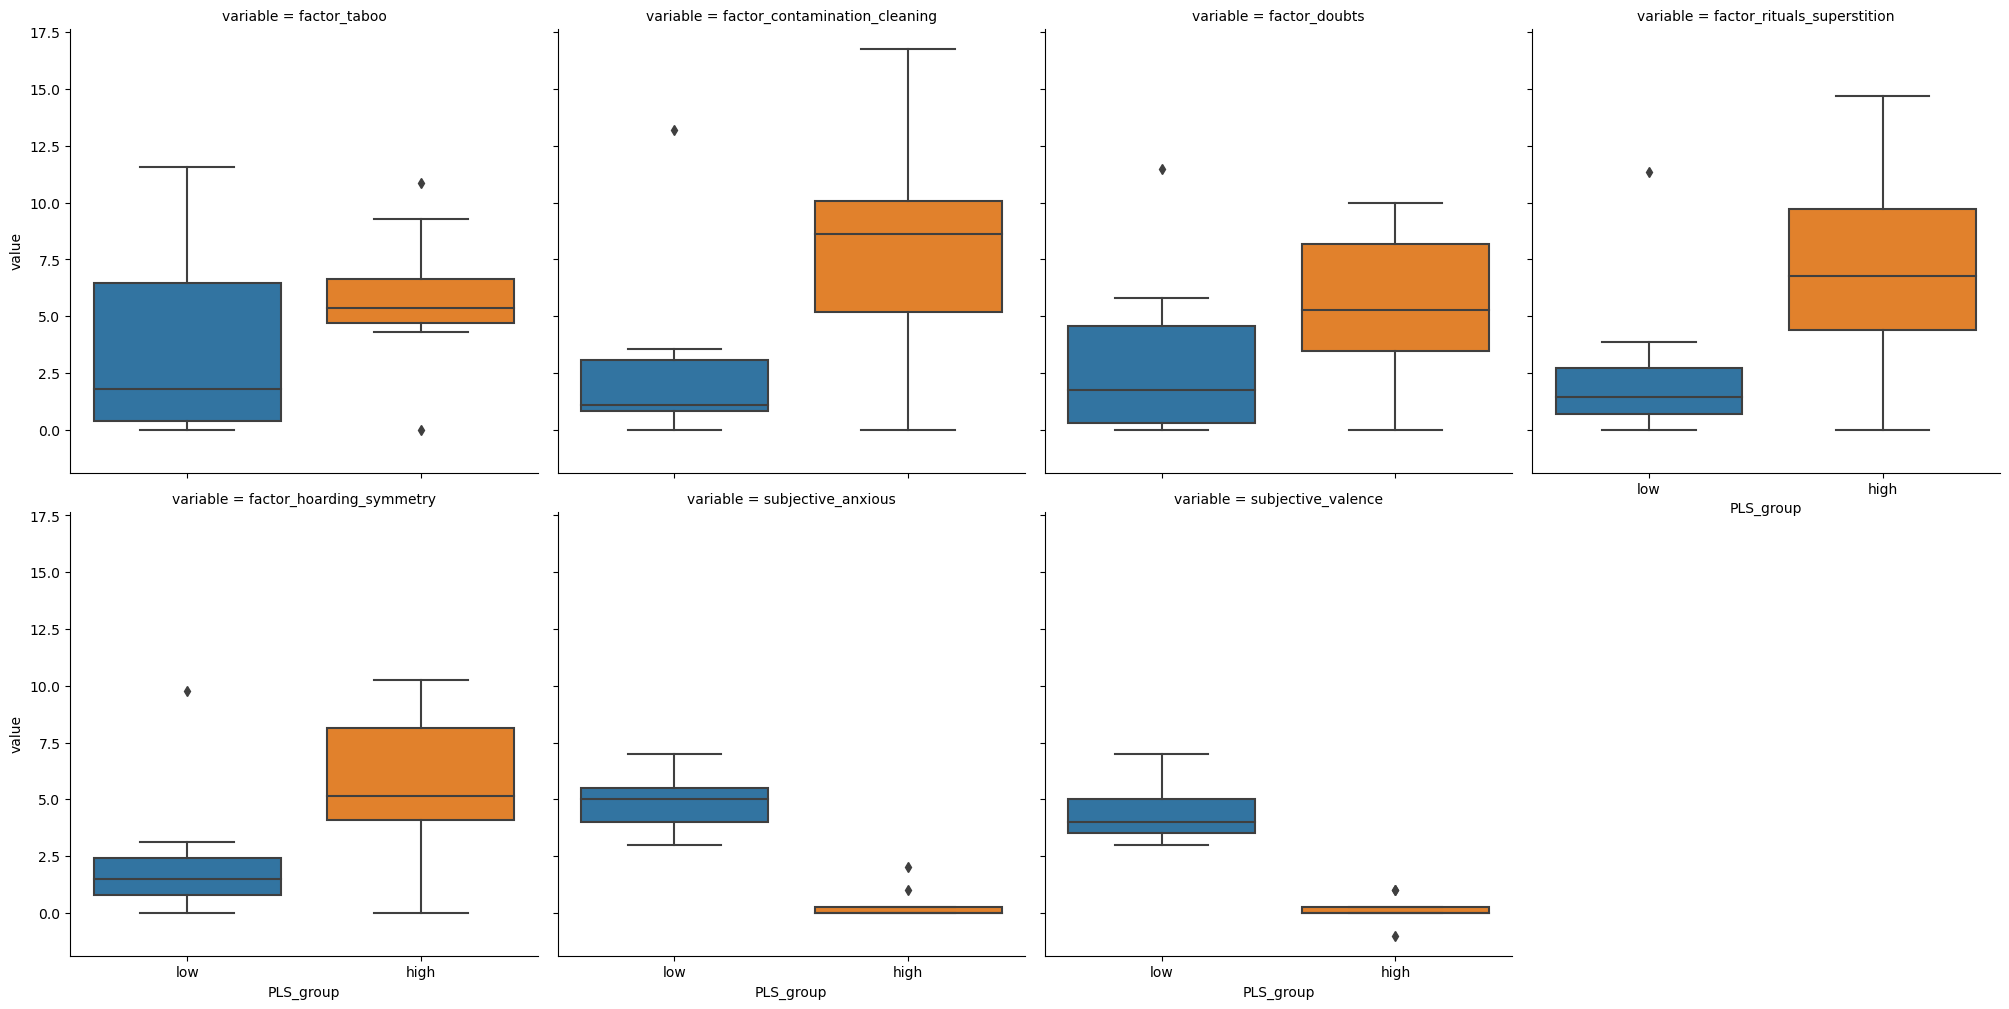

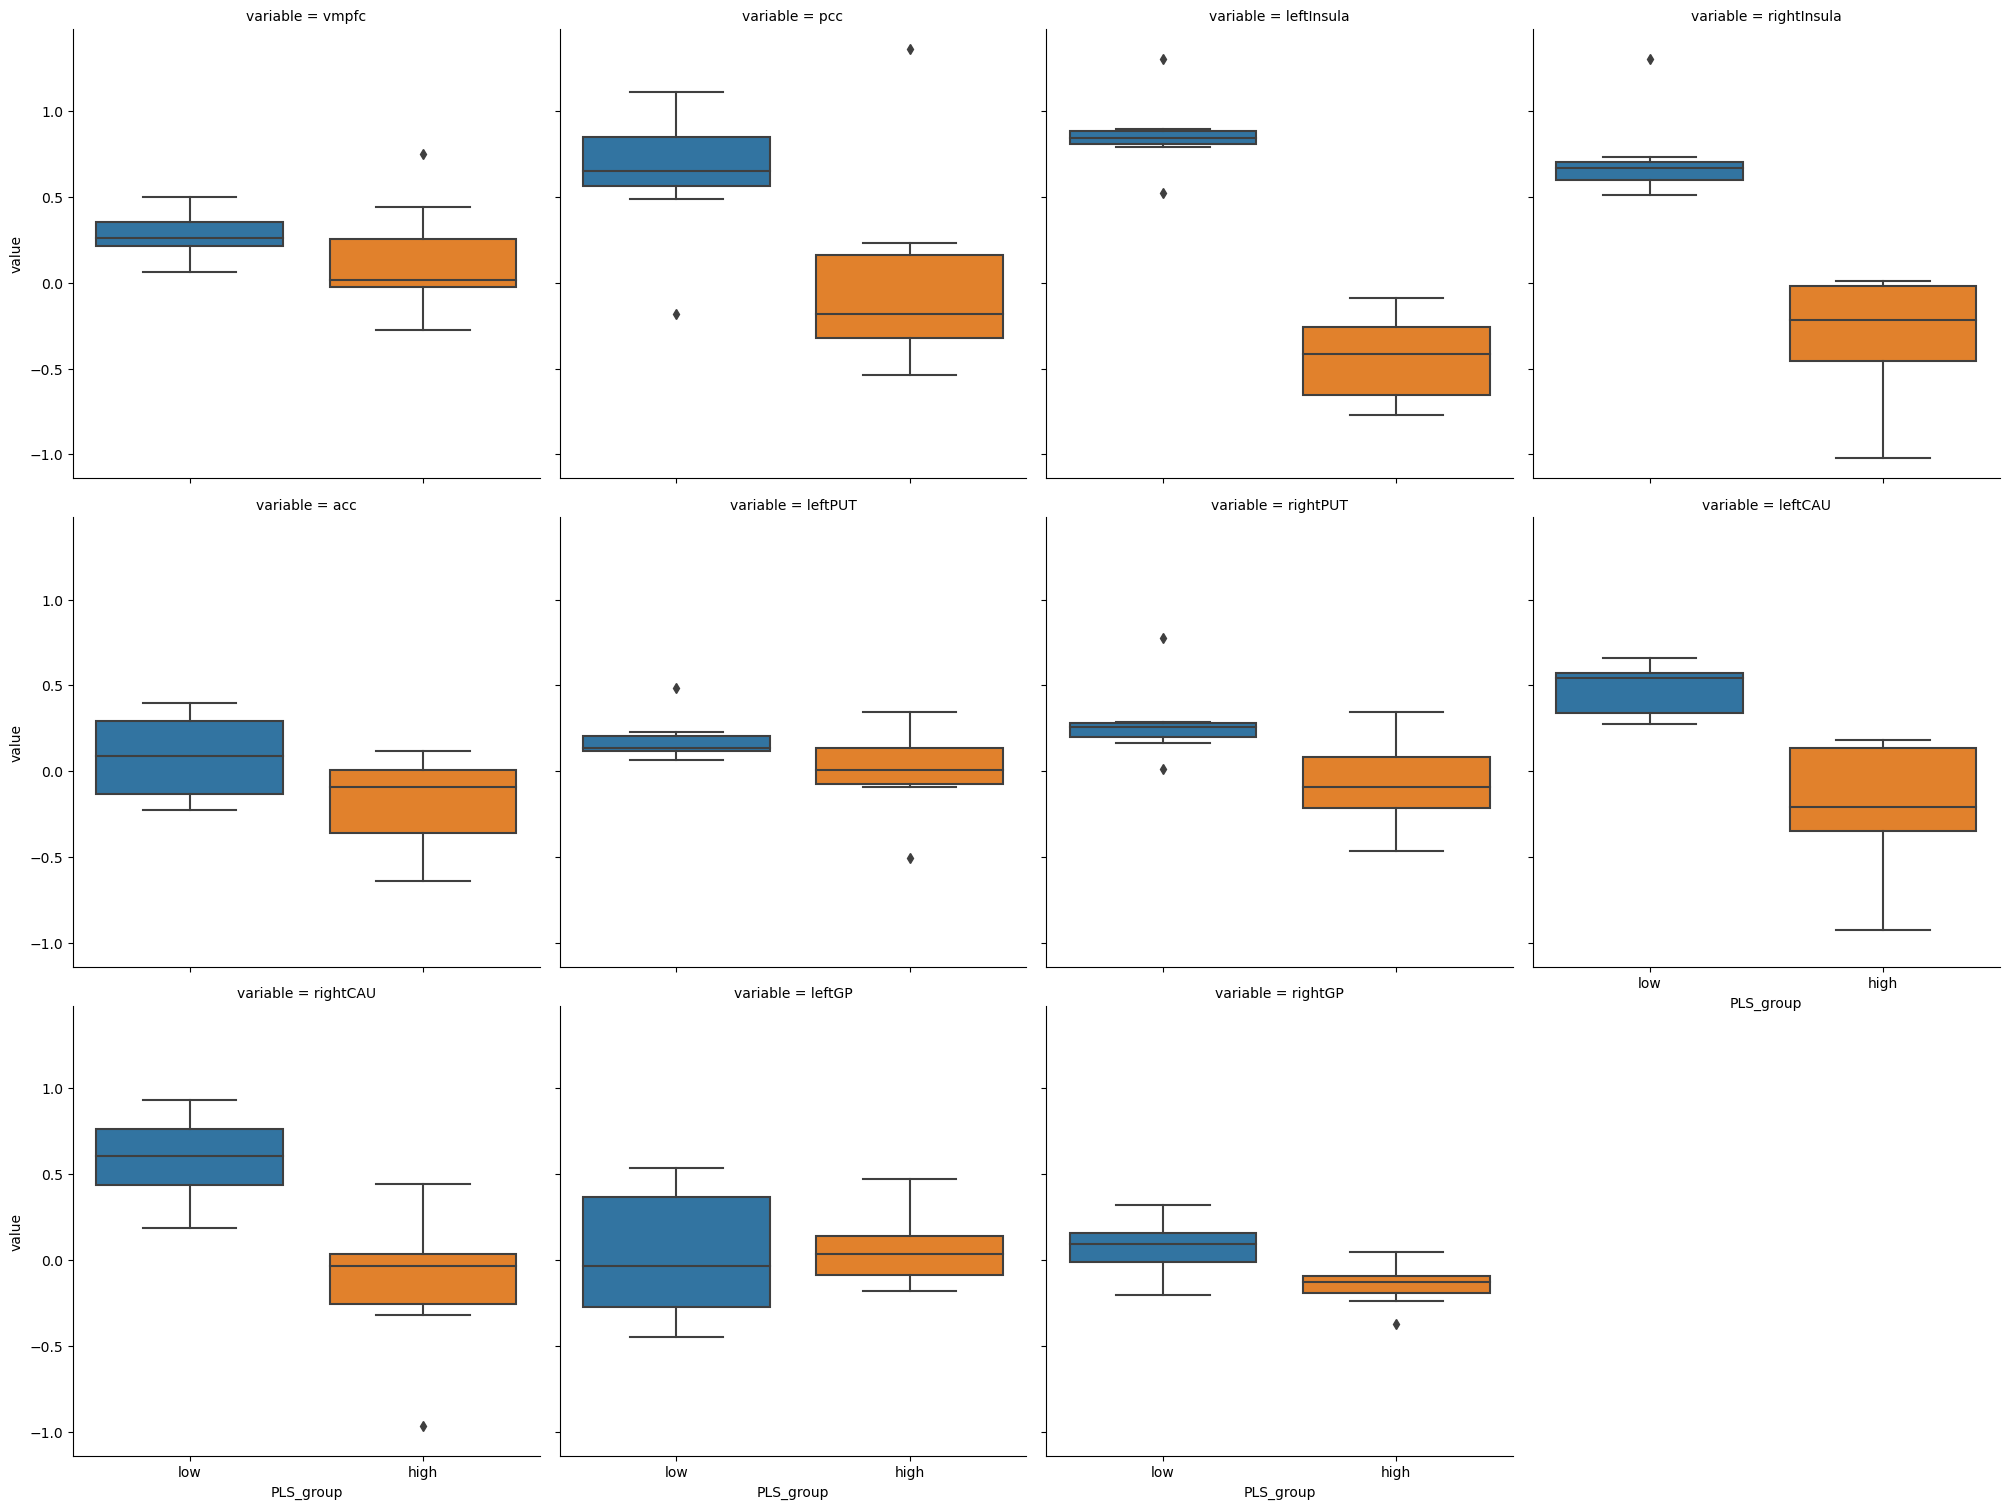

In [8]:
# take the top and bottom weighted subjects and plot their behav / activity
subj_high = pls_df.loc[(pls_df['X_scores_0'] > 1.2)
                       & (pls_df['y_scores_0'] > 1.2)]['participant_id'].values

subj_low = pls_df.loc[(pls_df['X_scores_0'] < -1.0)
                      & (pls_df['y_scores_0'] < -1.0)]['participant_id'].values

df = pd.read_csv('../results/PLSC/y_raw.csv')

df.loc[df.subj.isin(subj_high), 'PLS_group'] = 'high'
df.loc[df.subj.isin(subj_low), 'PLS_group'] = 'low'

# melt
df = pd.melt(df, id_vars=['subj', 'PLS_group'])
sns.catplot(kind='box', data=df, x='PLS_group', y='value', col='variable', col_wrap=4)
plt.show()

df = pd.read_csv('../results/PLSC/X_raw.csv')

df.loc[df.subj.isin(subj_high), 'PLS_group'] = 'high'
df.loc[df.subj.isin(subj_low), 'PLS_group'] = 'low'

# melt
df = pd.melt(df, id_vars=['subj', 'PLS_group'])
sns.catplot(kind='box', data=df, x='PLS_group', y='value', col='variable', col_wrap=4)
plt.show()

# Are non-aware participants driving the effect?

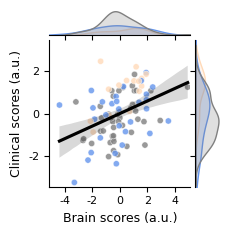

In [9]:
from functions.data_helpers import get_awareness_labels

pls_df['group-awareness'] = get_awareness_labels(subj_list)

palette = ['gray', 'cornflowerblue', 'peachpuff']
fig_dir = '../figures/'

# only the first component is significant
component = 0

# create scatter figure
xmax = max(abs(pls_df['X_scores_'+str(component)].values))+0.2
xmin = xmax*-1
ymax = max(abs(pls_df['y_scores_'+str(component)].values))+0.2
ymin = ymax*-1
plt.rcParams['svg.fonttype'] = 'none'

g = sns.jointplot(data=pls_df,
              x='X_scores_'+str(component),
              y='y_scores_'+str(component),
              hue='group-awareness',
              height=2.5,
              s=20,
              alpha=0.8,
              xlim=[xmin, xmax],
              ylim=[ymin, ymax],
              legend=False,
              palette=palette)

sns.regplot(data=pls_df,
            x='X_scores_'+str(component),
            y='y_scores_'+str(component),
            color='k', ax=g.ax_joint,
            scatter=False)

# change ticks and sizes
g.set_axis_labels(xlabel='Brain scores (a.u.)',
                  ylabel='Clinical scores (a.u.)', size=9)
ticks = np.arange(int(np.ceil(xmin)), int(np.ceil(xmax)))
if len(ticks) > 5:
    ticks = ticks[ticks % 2 == 0]
g.ax_joint.set_xticks(ticks)
g.ax_joint.set_xticklabels(ticks, fontsize=8)

ticks = np.arange(int(np.ceil(ymin)), int(np.ceil(ymax)))
if len(ticks) > 5:
    ticks = ticks[ticks % 2 == 0]
g.ax_joint.set_yticks(ticks)               
g.ax_joint.set_yticklabels(ticks, fontsize=8)

#plt.savefig(fig_dir+'PLS_clinical_correlation_comp'+str(component)+'.svg', dpi=300, pad_inches=0.2)
plt.show()


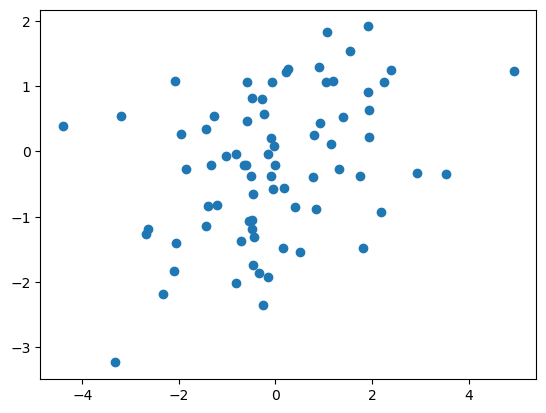

array([[1.        , 0.37602267],
       [0.37602267, 1.        ]])

In [10]:
# does the correlation still exist with non aware participants?
tmp = pls_df[pls_df['group-awareness'] != 'patient-unaware']
x = tmp.X_scores_0.values
y = tmp.y_scores_0.values

plt.scatter(x,y)
plt.show()

np.corrcoef(x,y)

# Do non-aware participants have a specific symptom profile?
No.

In [11]:
import pingouin as pg
# load the raw y data
df = pd.read_csv('../results/PLSC/y_raw.csv')
df['group-awareness'] = get_awareness_labels(subj_list)

# they are actually remarkably similiar!
df.groupby(['group-awareness']).mean()

for var in ['factor_taboo', 'factor_contamination_cleaning', 'factor_doubts',
            'factor_rituals_superstition', 'factor_hoarding_symmetry']:
    a = df[df['group-awareness'] == 'patient-aware'][var].values
    b = df[df['group-awareness'] == 'patient-unaware'][var].values
    res = pg.ttest(a, b)
    print(res)


              T        dof alternative     p-val          CI95%   cohen-d  \
T-test -0.99492  14.248998   two-sided  0.336372  [-5.62, 2.05]  0.395187   

         BF10     power  
T-test  0.504  0.179741  
               T        dof alternative     p-val          CI95%   cohen-d  \
T-test -0.671835  17.742553   two-sided  0.510343  [-4.18, 2.16]  0.237178   

         BF10     power  
T-test  0.412  0.095557  
              T        dof alternative     p-val          CI95%   cohen-d  \
T-test -0.60382  14.701006   two-sided  0.555167  [-4.36, 2.44]  0.235383   

         BF10     power  
T-test  0.399  0.094856  
               T       dof alternative     p-val          CI95%   cohen-d  \
T-test -0.229304  20.32382   two-sided  0.820924  [-2.92, 2.34]  0.076154   

         BF10     power  
T-test  0.355  0.054601  
               T        dof alternative     p-val          CI95%   cohen-d  \
T-test  0.121226  16.380949   two-sided  0.904987  [-2.35, 2.63]  0.044524   

        BF10 

# Solo symptoms (original model) do not result in a *strong* relationship

In [12]:
# parameters to consider:
eroded = False
n_X = 5
n_y = 5
n_comps = 2  # number of PLS components to investigate

# load the data
in_file = ('../results/PLSC/no_ratings/'
            + 'eroded-'+str(eroded)
            + '_Xnum-'+str(n_X)
            + '_ynum-'+str(n_y)
            + '.pkl')
with open(in_file, 'rb') as f:
    bpls = pickle.load(f)
    bpls_rev = pickle.load(f)
print('Results loaded')

# organise the results into dfs
pls_df = get_phenotype(subj_list, ['participants'])

# report the correlation and pval
for i in range(n_comps):
    print('Component',i)
    print('\tr=', np.corrcoef(bpls.x_scores[:,i], bpls.y_scores[:,i])[0,1])
    print('\tpFWE=',np.real(bpls.permres.pvals[i]))

    #save x/y_scores
    pls_df['X_scores_'+str(i)] = bpls.x_scores[:,i].copy()
    pls_df['y_scores_'+str(i)] = bpls.y_scores[:,i].copy()

Results loaded
Component 0
	r= 0.29947637946349787
	pFWE= 0.04599770011499425
Component 1
	r= 0.18012819588128945
	pFWE= 0.487925603719814


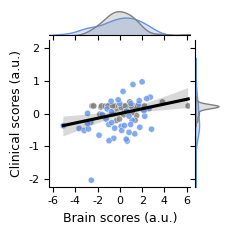

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

palette = ['gray', 'cornflowerblue']
fig_dir = '../figures/'

# only the first component is significant
component = 0

# create scatter figure
xmax = max(abs(pls_df['X_scores_'+str(component)].values))+0.2
xmin = xmax*-1
ymax = max(abs(pls_df['y_scores_'+str(component)].values))+0.2
ymin = ymax*-1
plt.rcParams['svg.fonttype'] = 'none'

g = sns.jointplot(data=pls_df,
              x='X_scores_'+str(component),
              y='y_scores_'+str(component),
              hue='group',
              height=2.5,
              s=20,
              alpha=0.8,
              xlim=[xmin, xmax],
              ylim=[ymin, ymax],
              legend=False,
              palette=palette)

sns.regplot(data=pls_df,
            x='X_scores_'+str(component),
            y='y_scores_'+str(component),
            color='k', ax=g.ax_joint,
            scatter=False)

# change ticks and sizes
g.set_axis_labels(xlabel='Brain scores (a.u.)',
                  ylabel='Clinical scores (a.u.)', size=9)
ticks = np.arange(int(np.ceil(xmin)), int(np.ceil(xmax)))
if len(ticks) > 5:
    ticks = ticks[ticks % 2 == 0]
g.ax_joint.set_xticks(ticks)
g.ax_joint.set_xticklabels(ticks, fontsize=8)

ticks = np.arange(int(np.ceil(ymin)), int(np.ceil(ymax)))
if len(ticks) > 5:
    ticks = ticks[ticks % 2 == 0]
g.ax_joint.set_yticks(ticks)               
g.ax_joint.set_yticklabels(ticks, fontsize=8)

plt.savefig(fig_dir+'PLSC_correlation_symptomsonly.svg', dpi=300, pad_inches=0.2)
plt.show()

In [14]:
def colors_from_values(values, palette_name):
    # normalize the values to range [0, 1]
    normalized = (values - min(values)) / (max(values) - min(values))
    # convert to indices
    indices = np.round(normalized * (len(values) - 1)).astype(np.int32)
    # use the indices to get the colors
    palette = sns.color_palette(palette_name, len(values))
    return np.array(palette).take(indices, axis=0)

In [15]:
values = r_y.copy()


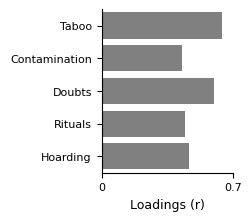

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import spearmanr


fig, axs = plt.subplot_mosaic("""
                              A
                              """, figsize=(2.4, 2.1), constrained_layout=True)
plt.rcParams['svg.fonttype'] = 'none'

# plot y (behav) loadings
y_labels_neat = ['Taboo', 'Contamination', 'Doubts',
                 'Rituals', 'Hoarding']

# get the raw data
y_raw = pd.read_csv('../results/PLSC/no_ratings/y_raw.csv')
y_raw = y_raw.drop(columns=['subj'])
y_raw_data = y_raw.values

# correlate with individual PLSC weights
a = bpls.y_scores[:,0]
r_y = []
for b_index in range(y_raw_data.shape[1]):
    b = y_raw_data[:, b_index]
    r, p = spearmanr(a, b)
    r_y.append(r * -1)  # flip the signs for better interpretation

plot_df = pd.DataFrame()
plot_df['variable'] = y_labels_neat
plot_df['correlation'] = r_y.copy()
sns.barplot(data=plot_df, y='variable', x='correlation', color='grey')

# change the fontsize / labels
axs['A'].set_yticklabels(y_labels_neat, fontsize=8)
axs['A'].set_xlabel('Loadings (r)', size=9)
axs['A'].set_ylabel('')
xticks = [0, 0.7]
axs['A'].set_xticks(xticks)
axs['A'].set_xticklabels(xticks, fontsize=8)
sns.despine(ax=axs['A'])
plt.savefig('../figures/PLSC_Behav_correlations_symptomsonly.svg', dpi=300, pad_inches=0.2)
plt.show()


In [26]:
#  brain plots
import nibabel as nib
from nilearn import plotting
from nilearn.image import new_img_like
from functions.data_helpers import get_computer

_, proj_dir = get_computer()

# roi information for plotting and statistics
bg_img = (proj_dir + 'data/derivatives/masks/'
          + 'tpl-MNI152NLin2009cAsym_res-01_desc-brain_T1w.nii.gz')
roi_dir = proj_dir+'data/derivatives/masks/'

# this order can be found in the PLSC_analysis script.
roi_dict = {'vmPFC': {'contrast': 'Safety',
                                  'label': ['vmpfc'],
                      'files': [roi_dir+'Savage_safety_vmpfc.nii.gz']
                      },
            'PCC': {'contrast': 'Safety',
                    'label': ['pcc'],
                    'files': [roi_dir+'Savage_safety_pcc.nii.gz']
                    },
            'Insula (left)': {'contrast': 'Threat',
                              'label': ['leftInsula'],
                              'files': [roi_dir+'Savage_threat_leftInsula.nii.gz']
                              },
            'Insula (right)': {'contrast': 'Threat',
                               'label': ['rightInsula'],
                               'files': [roi_dir+'Savage_threat_rightInsula.nii.gz']
                               },
            'dACC': {'contrast': 'Threat',
                     'label': ['acc'],
                     'files': [roi_dir+'Savage_threat_acc.nii.gz']
                     },

            'Putamen (left)': {'contrast': 'Threat',
                               'label': ['leftPUT'],
                               'files': [roi_dir+'tian_threat_leftPUT.nii.gz']
                               },
            'Putamen (right)': {'contrast': 'Threat',
                                'label': ['rightPUT'],
                                'files': [roi_dir+'tian_threat_rightPUT.nii.gz']
                                },
            'Caudate (left)': {'contrast': 'Threat',
                               'label': ['leftCAU'],
                               'files': [roi_dir+'tian_threat_leftCAU.nii.gz']
                               },
            'Caudate (right)': {'contrast': 'Threat',
                                'label': ['rightCAU'],
                                'files': [roi_dir+'tian_threat_rightCAU.nii.gz']
                                },
            'Globus pallidus (left)': {'contrast': 'Threat',
                                       'label': ['leftGP'],
                                       'files': [roi_dir+'tian_threat_leftGP.nii.gz']
                                       },
            'Globus pallidus (right)': {'contrast': 'Threat',
                                        'label': ['rightGP'],
                                        'files': [roi_dir+'tian_threat_rightGP.nii.gz']
                                        }
            }
# start figure
# get correlation values
X_raw = pd.read_csv('../results/PLSC/X_raw.csv')
X_raw = X_raw.drop(columns=['subj'])
X_raw_data = X_raw.values

a = bpls.x_scores[:, 0]
r_X = []
for b_index in range(X_raw_data.shape[1]):
    b = X_raw_data[:, b_index]
    r, p = spearmanr(a, b)
    r_X.append(r)
data = r_X.copy()

# create a brain image that has the values of the results
# in the space of the regions of interest
template = nib.load(roi_dict['PCC']['files'][0])
mask = np.zeros((template.shape))
for i, roi in enumerate(roi_dict):
    # load the roi
    roi_nii = nib.load(roi_dict[roi]['files'][0])

    # index and use value
    mask[roi_nii.get_fdata() == 1] = data[i] *-1 *-1  # to fit colormap then TO FIT OTHER RESULTS!

mask_nii = new_img_like(template, mask)

cut_coords = [2, 1]
plotting.plot_stat_map(mask_nii,
                       bg_img=bg_img,
                       cut_coords=cut_coords,
                       cmap='RdYlBu',
                       annotate=False,
                       draw_cross=False,
                       black_bg=False,
                       symmetric_cbar=True,
                       resampling_interpolation='continuous',
                       vmax=1,
                       output_file='../figures/PLSC_Brain_correlations_symptomsonly.svg',
                       display_mode='xz')
plt.show()


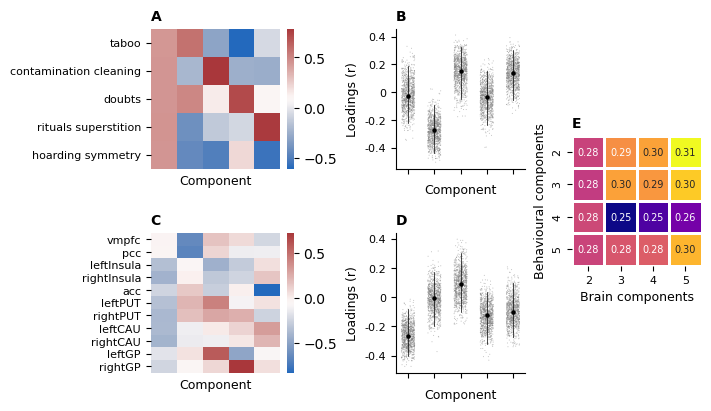

In [18]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# weight plots
fig, axs = plt.subplot_mosaic("""
                              CAE
                              DBE
                              """, figsize=(7, 4), constrained_layout=True)
plt.rcParams['svg.fonttype'] = 'none'


## Top plot: pca weights
df = pd.read_csv('../results/PLSC/no_ratings/y_raw.csv')
y_labels = df.columns.copy()[0:-1]

converter = lambda x: x.replace('_', ' ') # replace the underscores...
y_labels = list(map(converter, y_labels))
converter = lambda x: x.replace('factor ', '')
y_labels = list(map(converter, y_labels))

df.drop(labels='subj',axis='columns', inplace=True)
y_scaled = StandardScaler().fit_transform(df.values)

# perform PCA on y
pca = PCA(n_components=n_y).fit(y_scaled)
components = pca.components_.copy().T


sns.heatmap(data=components, linewidths=0, cbar=True, cmap='vlag', ax=axs['C'],
            yticklabels=y_labels, xticklabels=[])

axs['C'].set_xlabel('Component', fontsize=9)
axs['C'].tick_params(labelsize=8)
axs['C'].set_title('A', fontsize=10, weight='bold', loc='left')

# brain stuff (X)
df = pd.read_csv('../results/PLSC/X_raw.csv')
y_labels = df.columns.copy()[0:-1]
df.drop(labels='subj',axis='columns', inplace=True)
y_scaled = StandardScaler().fit_transform(df.values)

# perform PCA on y
pca = PCA(n_components=n_y).fit(y_scaled)
components = pca.components_.copy().T
sns.heatmap(data=components, linewidths=0, cbar=True, cmap='vlag', ax=axs['D'],
            yticklabels=y_labels, xticklabels=[])

axs['D'].set_xlabel('Component', fontsize=9)
axs['D'].tick_params(labelsize=8)
axs['D'].set_title('C', fontsize=10, weight='bold', loc='left')

## Bottom Plot: bootstraps
# we only want to keep a small number of bootstraps
# for visualisation otherwise the figure size
# gets out of hand
n_boots = 1000
y_labels = np.arange(1, n_y+1)
data = bpls.bootres.y_loadings_boot[:, component, :].T
ind = np.random.randint(0, data.shape[0], n_boots)
data = data[ind, :]
loadings = pd.DataFrame(data=data, columns=y_labels)
loadings = loadings.melt(value_vars=y_labels)

# plot y loadings
g = sns.stripplot(data=loadings,
              x='variable',
              y='value',
              color='grey',
              order = y_labels,
              alpha=0.50,
              size=0.75,
              jitter=0.25,
              ax=axs['A'],
              zorder=0)

# change the fontsize / labels
axs['A'].set_xlabel('Component', size=9)
axs['A'].set_ylabel('Loadings (r)', size=9)

axs['A'].set_xticks(range(n_y+1))
axs['A'].set_xticklabels('', fontsize=8)
yticks = [-0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6]
axs['A'].set_yticks(yticks)
axs['A'].set_yticklabels(yticks, fontsize=8)

# plot CIs (these are calculated from ALL bootstraps)
for i in range(bpls.bootres.y_loadings_ci.shape[0]):
    ci = bpls.bootres.y_loadings_ci[i, component]
    axs['A'].plot( [i, i], [ci[0], ci[1]], 'k', linewidth=0.5, zorder=1)

# plot means
x = range(len(bpls.bootres.y_loadings[:,component]))
axs['A'].scatter(x, bpls.bootres.y_loadings[:, component], color='k', s=5, zorder=1)
sns.despine(ax=axs['A'])
axs['A'].set_title('B', fontsize=10, weight='bold', loc='left')

# plot the X loadings!
data = bpls_rev.bootres.y_loadings_boot[:, component, :].T
ind = np.random.randint(0, data.shape[0], n_boots)
data = data[ind, :]
loadings = pd.DataFrame(data=data, columns=y_labels)
loadings = loadings.melt(value_vars=y_labels)

# plot X loadings
g = sns.stripplot(data=loadings,
              x='variable',
              y='value',
              color='grey',
              order = y_labels,
              alpha=0.50,
              size=0.75,
              jitter=0.25,
              ax=axs['B'],
              zorder=0)

# change the fontsize / labels
axs['B'].set_xlabel('Component', size=9)
axs['B'].set_ylabel('Loadings (r)', size=9)

axs['B'].set_xticks(range(n_y+1))
axs['B'].set_xticklabels('', fontsize=8)
yticks = [-0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6]
axs['B'].set_yticks(yticks)
axs['B'].set_yticklabels(yticks, fontsize=8)

# plot CIs (these are calculated from ALL bootstraps)
for i in range(bpls_rev.bootres.y_loadings_ci.shape[0]):
    ci = bpls_rev.bootres.y_loadings_ci[i, component]
    axs['B'].plot( [i, i], [ci[0], ci[1]], 'k', linewidth=0.5, zorder=1)

# plot means
x = range(len(bpls_rev.bootres.y_loadings[:,component]))
axs['B'].scatter(x, bpls_rev.bootres.y_loadings[:, component], color='k', s=5, zorder=1)
sns.despine(ax=axs['B'])
axs['B'].set_title('D', fontsize=10, weight='bold', loc='left')

r_mat = np.zeros((4,4))

for n_X in range(2,6):
    for n_y in range(2,6):

        # load the data
        in_file = ('../results/PLSC/no_ratings/'
                    + 'eroded-'+str(eroded)
                    + '_Xnum-'+str(n_X)
                    + '_ynum-'+str(n_y)
                    + '.pkl')
        with open(in_file, 'rb') as f:
            bpls = pickle.load(f)
            bpls_rev = pickle.load(f)

        # we just want to collect the first (sig) components r value
        r = np.corrcoef(bpls.x_scores[:,0], bpls.y_scores[:,0])[0,1]
        r_mat[n_X-2,n_y-2] = r.copy()


sns.heatmap(data=r_mat, linewidths=1, cbar=False, cmap='plasma', square=True,
            annot=True, fmt='.2f', annot_kws={"size": 7},
            xticklabels=['2', '3', '4', '5'],
            yticklabels=['2', '3', '4', '5'], ax=axs['E'])
axs['E'].set_xlabel('Brain components', fontsize=9)
axs['E'].set_ylabel('Behavioural components', fontsize=9)

axs['E'].tick_params(labelsize=8)
axs['E'].set_title('E', fontsize=10, weight='bold', loc='left')
plt.savefig('../figures/PLSC_PCA_reliability_symptomsOnly.png')
plt.show()

# Unpack the symptom PLS

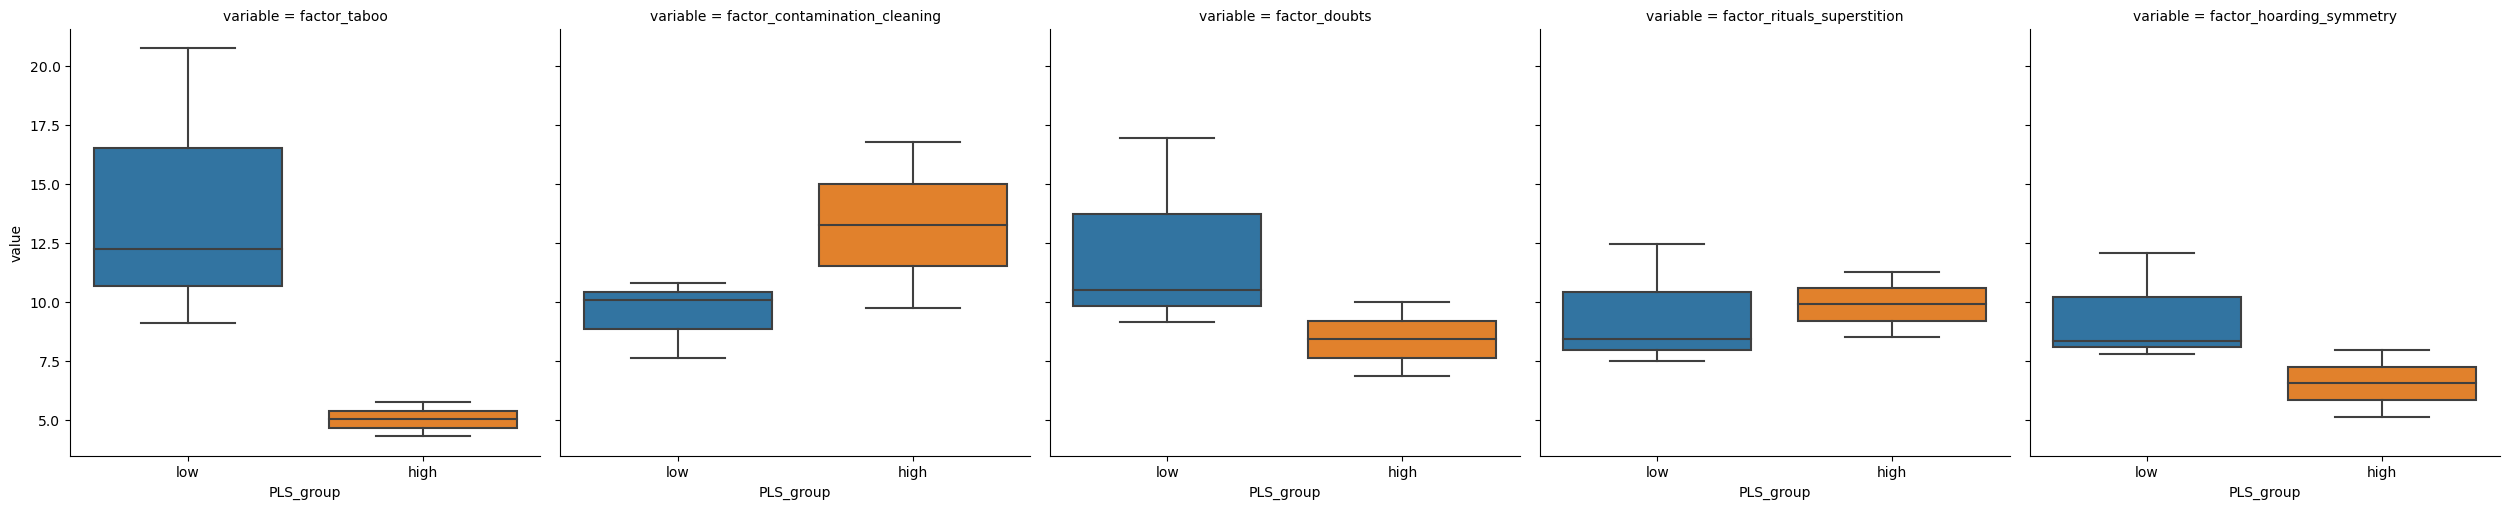

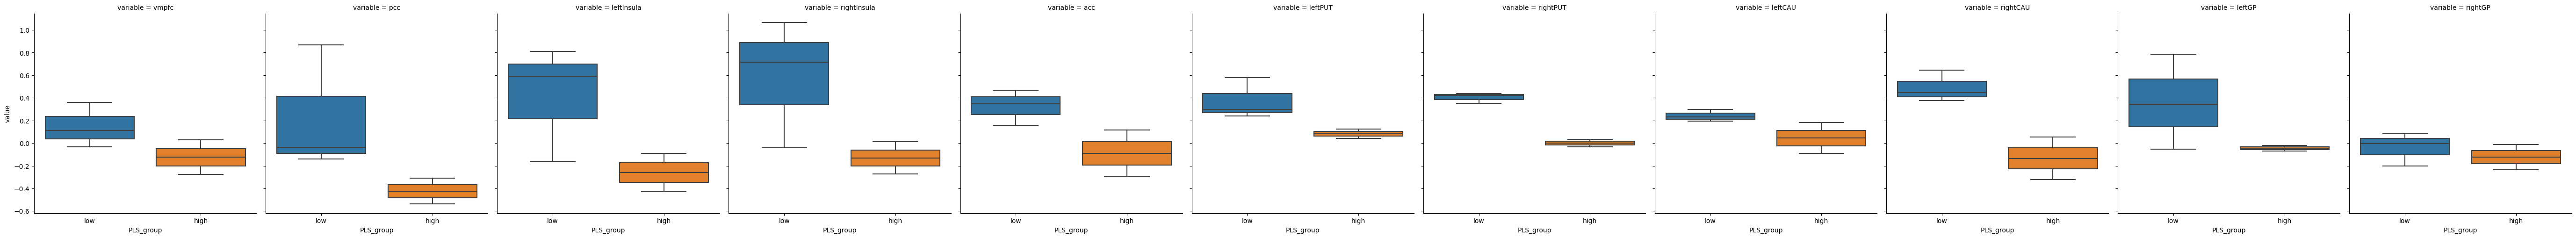

/home/lukeh/miniconda3/envs/py39/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedCheckFailedWarning: Failed to check for latest version of package.
Set the environment variable OUTDATED_RAISE_EXCEPTION=1 for a full traceback.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [27]:
# take the top and bottom weighted subjects and plot their behav / activity
subj_high = pls_df.loc[(pls_df['X_scores_0'] > 1)
                       & (pls_df['y_scores_0'] > 0.8)]['participant_id'].values

subj_low = pls_df.loc[(pls_df['X_scores_0'] < -1.0)
                      & (pls_df['y_scores_0'] < -0.5)]['participant_id'].values

df = pd.read_csv('../results/PLSC/no_ratings/y_raw.csv')

df.loc[df.subj.isin(subj_high), 'PLS_group'] = 'high'
df.loc[df.subj.isin(subj_low), 'PLS_group'] = 'low'

# melt
df = pd.melt(df, id_vars=['subj', 'PLS_group'])
sns.catplot(kind='box', data=df, x='PLS_group', y='value', col='variable')
plt.show()

df = pd.read_csv('../results/PLSC/X_raw.csv')

df.loc[df.subj.isin(subj_high), 'PLS_group'] = 'high'
df.loc[df.subj.isin(subj_low), 'PLS_group'] = 'low'

# melt
df = pd.melt(df, id_vars=['subj', 'PLS_group'])
sns.catplot(kind='box', data=df, x='PLS_group', y='value', col='variable')
plt.show()

In [20]:
subj_high

array(['sub-patient25', 'sub-patient38'], dtype=object)